## Preliminaries for data processing and analysis

In [1]:
%matplotlib inline
import numpy as np
import pandas

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.cross_validation import cross_val_score,LeaveOneOut,ShuffleSplit
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import scale
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier,OutputCodeClassifier

import scratch as s

Using Theano backend.


## Load, format, and reshape all the Banner Brain and Body Donation Program data

In [2]:
# Load the BBDP excel files, and index by donor ID.  
clinpath = pandas.read_excel('./bbdp/data/Clinicopathological Correlations.xls')
movement = pandas.read_excel('./bbdp/data/Movement Examination.xls')
neuro = pandas.read_excel('./bbdp/data/Neurological Examination.xls')
psych = pandas.read_excel('./bbdp/data/Neuropsychological Examination.xls')
mmse_all = pandas.read_excel('./bbdp/data/MMSE Scores All Sources.xls')
mmse_bbdp = pandas.read_excel('./bbdp/data/MMSE Scores BBDP.xls')
for x in [clinpath,movement,neuro,psych,mmse_all,mmse_bbdp]:
    x.set_index('Donor ID', drop=True, append=False, inplace=True)

In [3]:
# Load the excel file that Joe sent, which contains those subjects for whom UPSIT data is available.  
guide = pandas.read_excel('bbdp/data/D20Mar2015a.xls')
dementia_labels = [row[0] for _,row in guide.iterrows() \
                   if row[2].__class__.__name__ == 'str' and 'Yes with Dementia' in row[2]]
df = pandas.read_excel('bbdp/data/D20Mar2015a.xls',sheetname='Data')

# Create a data frame with this smell data.  
smell = df[['donor_id','shri_case_num','stint','deathage','smell_reduced_or_absent']]#+['smell_%d' % q for q in range(1,41)]]
smell.insert(3,'dementia',[np.any([row[col_label]==2 for col_label in dementia_labels]) \
                           for row_label,row in df.iterrows()])
smell.insert(3,'test_age',df['deathage'] - df['stint'])

# Load the smell test key from the excel file that Brittany sent.  
smell_test_key = pandas.read_excel('bbdp/data/GerkinSmithUPSITautopsy9_10_14.xlsx',sheetname='smellTestKey')
smell_test_key = smell_test_key['Correct answer']
smell_matrix = df[['smell_%d' % q for q in range(1,41)]].as_matrix()
for q in range(40):
    smell_matrix[:,q] = (smell_matrix[:,q] == smell_test_key[q])
smell.insert(3,'upsit_total',smell_matrix.sum(axis=1))
smell.rename(columns={'donor_id':'Donor ID', 'shri_case_num': 'Case ID'}, inplace=True)
# Add an indicator variable for whether a given response ('a','b',...) was selected or not, for each question.  
for q in range(1,41):
    for i,letter in enumerate(['a','b','c','d']):
        smell.insert(len(list(smell)),'smell_%d%s' % (q,letter),df['smell_%d' % q]==(i+1))

smell.set_index('Donor ID', drop=True, append=False, inplace=True)

/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/pandas/core/frame.py:2697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [4]:
# Join all the data sources into one data frame.  
raw = smell.join(clinpath,how='left',rsuffix='_cp')\
           .join(movement,how='left',rsuffix='_nr')\
           #.join(smell,how='left',rsuffix='_sl')\
           #.join(neuro,how='left',rsuffix='_nr')\
           #.join(psych,how='left',rsuffix='_ps')\
           #.join(mmse_all,how='left',rsuffix='_ma')\
           #.join(mmse_bbdp,how='left',rsuffix='_mb')\
raw.drop(['Case ID'+x for x in ['_cp','_nr','_ps','_ma','_mb','_sl']],inplace=True,axis=1,errors='ignore')
raw.drop(['Donor ID'+x for x in ['_cp','_nr','_ps','_ma','_mb']],inplace=True,axis=1,errors='ignore')
raw.drop(['Refresh Date'+x for x in ['','_cp','_nr','_ps','_ma','_mb']],inplace=True,axis=1,errors='ignore')
raw.reset_index(inplace=True)

## Impute missing data prior to model fitting and create data matrices.  

In [5]:
# Create a dictionary of all the numbers that correspond to NaN/None/Unavailable, so that these values
# in each column can be replaced with NaN consistently prior to imputation.  
NaN = {}
NaN[99] = ['Autopsy Type','Race','Hispanic','Education Years',
          'Occupation','Handedness','Expired Reason','Plaque Total',
          'Tangle Total','Braak Tangle Score','Lewy Sum Density Brain',
          'Lewy Sum Density Body','CAA Total','CDR Sum','Global D Scale',
          'FAST Score','GERI D Score','Names in 60 Seconds','Figure Recall Score',
          'Clock Drawing','Hachinski Ischemic Score','MMSE Score',
          'MMSE Possible Score','AVLT Total Learning','AVLT Trial 1','AVLT Trial 2',
          'AVLT Trial 3','AVLT Trial 4','AVLT Trial 5','AVLT Intrusions 1-5',
          'AVLT STM A6','AVLT Intrusions STM','AVLT LTM A7','AVLT List B',
          'AVLT Recognition TP','AVLT Recognition FP','Judgement of Line Orientation',
          'WMSR Digit Span Forward Score','WMSR Digit Span Forward Span',
          'WMSR Digit Span Backward Score','WMSR Digit Span Backward Span',
          'WMSR Digit Span Total Score','Trials A Errors','Trails B Errors',
          'UPDRS I Intellectual Impairment','UPDRS I Thought Disorder Score',
          'UPDRS I Depression Score','UPDRS I Motivation Initiative',
          'UPDRS II*','UPDRS III*','UPDRS IV*','Restless Leg Syndrome','RLS Score',
          'Modified Hoehn and Yahr Stage','Postural Tremor Right',
          'Postural Tremor Left','Kinetic Tremor Right','Kinetic Tremor Left',
          'Voice Tremor','Head Tremor','Blepharospasm','OMD',
          'Torticollis','Limb Dystonia','Myoclonus','Tics','Chorea','Downgaze Palsy',
          'Square Wave Jerks','Timed Tapping Score Right','Timed Tapping Score Left',
          'Purdue Pegboard Score Right','Purdue Pegboard Score Left',
          'Purdue Pegboard Both Hands','Control No Movement Disorder DX',
          'Parkinsonism DX','Tremor DX','Dystonia DX','Dystonia Cranial DX',
          'Dystonia Cervical DX','Dystonia Laryngeal DX','Dystonia Limb DX',
          'Dystonia Trunk DX','Chorea DX','Tardive Dyskinesia or Dystonia DX',
          'Myoclonus DX','Tic DX','Ataxia DX','RLS DX','PLMS DX',
          'REM Behavior Disorder DX','NPH DX','PD Symptoms Bradykinesia',
          'PD Symptoms Rest Tremor','PD Symptoms Rigidity',
          'PD Symptoms Postural Instability','PD Symptoms Asymmetric Onset',
          'PD Symptoms Persistent Asymmetry','PD Symptoms Response to TX',
          'PD Symptoms Motor Fluctuations','PD Symptoms Dyskinesia',]
NaN[999] = ['Medical Records Total Months','Last BMI Score',
           'Last BMI Interval Before Death','BMI Mean Score',
           'BMI First to Last Interval','Last MMSE Test Score',
           'Last MMSE Interval Before Death','Last UPDRS Motor Score On Medication',
           'Last UPDRS Motor Score Off Medication','Last UPDRS Interval Before Death',
           'AVLT Percent Recall','Trails A 3 Min Limit','Trails B 5 Minute Limit',
           'Stroop Word Naming','Stroop Color Naming','Stroop Word Color',
           'Stroop Uncorrected Errors','Stroop Interference','COWA Fluency 1',
           'COWA Fluency 2','COWA Fluency Total','COWA Word Perseverations',
           'COWA Fluency Intrusions','COWA Animal Fluency',
           'COWA Animal Perseverations','Hamilton Depression Scale',
           'Hours Since Last PD Med Dose','PD Certainty Percent']
NaN[9] = ['Postmortem Parkinsonism','Postmortem Global CDR Score','MCI',
         'Clinpath Control','Lewy Bodies NOS','Dementia Nos','Clinpath AD',
         'Clinpath PD','Clinpath DLB','Clinpath VaD','Clinpath PSP','Clinpath HS',
         'Clinpath DLDH','Clinpath MND','Clinpath CBD','Clinpath PICKS','Clinpath HD',
         'Clinpath MSA','ARG','Clinpath FTLD-TDP43','TDP43NOS','Plaque Frontal',
         'Plaque Temporal','Plaque Parietal','Plaque Hippocampus','Plaque Entorhinal',
         'Neuritic Plaque Density','Tangle Frontal','Tangle Temporal',
         'Tangle Parietal','Tangle Hippocampus','Tangle Entorhinal','NIA Reagan',
         'USSLBD','SN Depigmentation','Lewy Olfactory Bulb','Lewy Brainstem IX X',
         'Lewy Brainstem LC','Lewy Brainstem SN','Lewy Amygdala','Lewy Transentorhinal',
         'Lewy Cingulate','Lewy Frontal','Lewy Temporal','Lewy Parietal','Lewy Cervical',
         'Lewy Thoracic','Lewy Lumbar','Lewy Sacral','Lewy Vagus Nerve',
         'Lewy Submondibular','Lewy Esophagus','CAA Frontal','CAA Temporal',
         'CAA Parietal','CAA Occipital','Circle of Willis','CDR Global',
         'Dystonia Trunk DX']
NaN[900] = ['Clinpath PD']
NaN[9999] = ['Brain Weight Grams','Infarct Cortical Volume',
            'Infarct Centrum Ovale Volume','Infarct Deep Nuclei Volume',
            'Infarct Infratentorial Volume','Infarct Brain Total Volume',
            ]
NaN[8] = ['Circle of Willis','UPDRS II*','UPDRS III*','UPDRS IV*']

In [6]:
# Make a copy of the data frame before setting NaN/None/Unavailable numeric values to NaN.  
clean = raw.copy()

# Replace numeric versions of NaN/None/Unavailable with actual NaN.  
import fnmatch
for val in NaN.keys():
    features = NaN[val]
    replacements = {}
    for feature in features:
        all_features = list(raw)
        matches = [f for f in all_features if fnmatch.fnmatch(f,feature)]
        #assert len(matches), "No feature matching '%s' was found" % feature
        for match in matches:
            replacements[match] = np.nan
    clean.replace(to_replace=val, value=replacements, inplace=True)
    clean.replace(to_replace=str(val), value=replacements, inplace=True)
    
# Replace letter scores with decimals. 
if 'FAST Score' in list(clean):
    for i,val in enumerate(clean['FAST Score']):
        if type(val) != float:
            for letter,decimal in [('a','.0'),('b','.2'),('c','.4'),('d','.6'),('e','.8')]:
                val = val.replace(letter,decimal)
            clean.set_value(i,'FAST Score',float(val))
        
# Replace hyphens with decimals.  
for i,val in enumerate(clean['Case ID']):
    clean.set_value(i,'Case ID',float(val.replace('-','.')))
        
# Remove these two columns because they have too many possible values and won't be useful to the model.  
clean.drop(['Occupation','Expired Reason'],inplace=True,axis=1)

In [7]:
# These are the columns corresponding to post-mortem pathology.  
path_cols = ['Brain Weight Grams','MCI','Clinpath Control','Lewy Bodies NOS','Dementia Nos',
 'Clinpath AD','Clinpath PD','Clinpath DLB','Clinpath VaD','Clinpath PSP','Clinpath HS','Clinpath DLDH',
 'Clinpath MND','Clinpath CBD','Clinpath PICKS','Clinpath HD','Clinpath MSA','ARG','Clinpath FTLD-TDP43',
 'TDP43NOS','Plaque Frontal','Plaque Temporal','Plaque Parietal','Plaque Hippocampus','Plaque Entorhinal',
 'Plaque Total','Neuritic Plaque Density','Tangle Frontal','Tangle Temporal','Tangle Parietal','Tangle Hippocampus',
 'Tangle Entorhinal','Tangle Total','Braak Tangle Score','NIA Reagan','USSLBD','SN Depigmentation',
 'Lewy Olfactory Bulb','Lewy Brainstem IX X','Lewy Brainstem LC','Lewy Brainstem SN','Lewy Amygdala',
 'Lewy Transentorhinal','Lewy Cingulate','Lewy Temporal','Lewy Frontal','Lewy Parietal','Lewy Sum Density Brain',
 'Lewy Cervical','Lewy Thoracic','Lewy Lumbar','Lewy Sacral','Lewy Vagus Nerve','Lewy Submondibular',
 'Lewy Esophagus','Lewy Sum Density Body','CAA Frontal','CAA Temporal','CAA Parietal','CAA Occipital',
 'CAA Total','Circle of Willis','Infarct Cortical Volume','Infarct Centrum Ovale Volume',
 'Infarct Deep Nuclei Volume','Infarct Infratentorial Volume','Infarct Brain Total Volume']

# This is the subset of the pathology columns that have binary outcomes (present/absent).  
binary_cols = ['MCI','Clinpath Control','Lewy Bodies NOS','Dementia Nos','Clinpath AD','Clinpath PD',
                'Clinpath DLB','Clinpath VaD','Clinpath PSP','Clinpath HS','Clinpath DLDH','Clinpath MND',
                'Clinpath CBD','ARG','Clinpath FTLD-TDP43']

# Make a Y matrix (to be predicted) using only the binary outcomes.  
Y_clean = clean[binary_cols]

# Make a Y matrix (to be predicted) using all pathological outcomes, including non-binary ones.  
#Y_clean = clean[path_cols]

# Make an X matrix (used for prediction) out of all non-pathological (i.e. all clinical) measurements, 
# except of course the actual ID's of the subjects themselves.  
X_clean = clean.drop(path_cols,axis=1).drop(['Donor ID','Case ID'],axis=1)

# Similarly, make an X matrix that uses all of the above except smell information.  
X_clean_nosmell = X_clean.drop(list(smell),axis=1,errors='ignore')

# Similarly, make an X_matrix that uses all of the above except non-smell-related clinical information about PD.  
park = ['Tapping','MMSE','CDR','Movement','Restless','RLS','Hoehn','Tremor','Blepharospasm','OMD','Torticollis','Dystonia','Myoclonus','Tics','Chorea','Palsy',
        'Jerks','Purdue','DX','Park','PD']
X_clean_nopark = X_clean.drop([x for x in list(X_clean) if any([a in x for a in park])],axis=1)

## Perform missing data imputation  

In [8]:
# Use K-nearest neighbors (and optionally other algorithms) to compute matrices with missing data imputed.  
imps = ['knn',]#'nnm','softimpute']
X = s.imputation(X_clean,imps=imps)
Y = s.imputation(Y_clean,imps=imps)
X_nosmell = s.imputation(X_clean_nosmell,imps=imps)
X_nopark = s.imputation(X_clean_nopark,imps=imps)

Computing pairwise distances between 879 samples
Computing distances for sample #1/879, elapsed time: 0.170
Computing distances for sample #101/879, elapsed time: 0.304
Computing distances for sample #201/879, elapsed time: 0.442
Computing distances for sample #301/879, elapsed time: 0.576
Computing distances for sample #401/879, elapsed time: 0.707
Computing distances for sample #501/879, elapsed time: 0.839
Computing distances for sample #601/879, elapsed time: 0.974
Computing distances for sample #701/879, elapsed time: 1.106
Computing distances for sample #801/879, elapsed time: 1.240
Imputing row 1/879 with 62 missing columns, elapsed time: 1.386
Imputing row 101/879 with 73 missing columns, elapsed time: 1.469
Imputing row 201/879 with 73 missing columns, elapsed time: 1.566
Imputing row 301/879 with 76 missing columns, elapsed time: 1.657
Imputing row 401/879 with 52 missing columns, elapsed time: 1.738
Imputing row 501/879 with 35 missing columns, elapsed time: 1.816
Imputing r

## Fit the full model and display results

In [9]:
all_features = list(X_clean)
all_props = list(Y_clean)
props = [prop for prop in all_props if prop not in ['Clinpath CBD','Clinpath MND','Clinpath DLDH','Clinpath HS','Clinpath FTLD-TDP43']]

In [10]:
x = np.empty((len(props),len(props)))
for i,prop1 in enumerate(props):
    for j,prop2 in enumerate(props):
        x[i,j] = (Y_clean[prop1] * Y_clean[prop2]).sum()

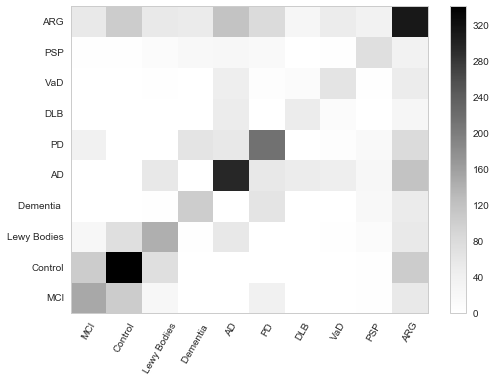

In [11]:
props2 = [prop.replace('Clinpath ','').replace(' NOS','').replace('Nos','') for prop in props]
plt.pcolor(x)
plt.xticks(np.arange(0.5,len(props)+5),props2,rotation=60);
plt.yticks(np.arange(0.5,len(props)+5),props2);
plt.xlim(0,10)
plt.ylim(0,10)
plt.colorbar()

In [12]:
x = Y_clean['Clinpath PD'] + Y_clean['Clinpath PSP'] > 0
indices = np.nonzero(x)

In [13]:
kwargs = {'props':all_props,
          'labels':list(clean['Donor ID']), # Use this to make sure test/train splits keep 
                                           # a given subject (across multiple observations)
                                           # entirely in the training set or entirely in the test set.  
          'n_splits':100,
          'clf_args':{'n_estimators':50,
                      'max_features':'auto',
                      'criterion':'entropy',
                      'random_state':0}
          }

In [15]:
rs,_,ys,ps = s.fit_models_mc(imps, X, Y, all_props, **kwargs)
rs,_,ys_nosmell,ps_nosmell = s.fit_models_mc(imps, X_nosmell, Y, all_props, **kwargs)
rs,_,ys_nopark,ps_nopark = s.fit_models_mc(imps, X_nopark, Y, all_props, **kwargs)

In [16]:
if False:
    x_diag = 'Clinpath PD'
    y_diag = 'Clinpath PSP'
    p_x,p_y,o_x,o_y = s.scatter_diag(props,ps,ys,x_diag,y_diag,plot=False)
    p_x_ns,p_y_ns,o_x_ns,o_y_ns = s.scatter_diag(props,ps_nosmell,ys_nosmell,x_diag,y_diag,plot=False)
    p_x_np,p_y_np,o_x_np,o_y_np = s.scatter_diag(props,ps_nopark,ys_nopark,x_diag,y_diag,plot=False)
    s.roc_showdown(p_x,p_y,o_x,o_y,x_diag,y_diag,title='All',color='purple')
    s.roc_showdown(p_x_ns,p_y_ns,o_x_ns,o_y_ns,x_diag,y_diag,title='No Smell Info',color='red')
    s.roc_showdown(p_x_np,p_y_np,o_x_np,o_y_np,x_diag,y_diag,title='No PD Info',color='blue')

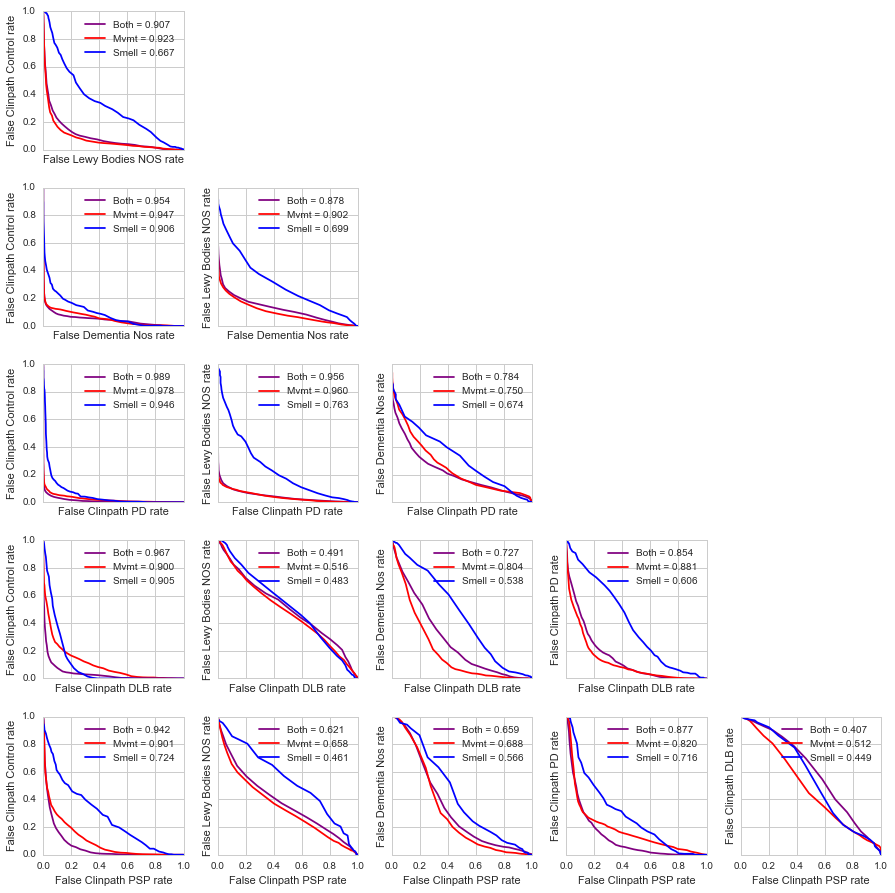

In [20]:
props = ['Clinpath Control','Lewy Bodies NOS','Dementia Nos','Clinpath PD',
                'Clinpath DLB','Clinpath PSP']
fig,axes = plt.subplots(len(props),len(props),sharex=True,sharey=True,figsize=(15,15))
for i,x_diag in enumerate(props):
    for j,y_diag in enumerate(props):
        if i<=j:
            continue
        p_x,p_y,o_x,o_y = s.scatter_diag(all_props,ps,ys,x_diag,y_diag,plot=False)
        p_x_ns,p_y_ns,o_x_ns,o_y_ns = s.scatter_diag(all_props,ps_nosmell,ys_nosmell,x_diag,y_diag,plot=False)
        p_x_np,p_y_np,o_x_np,o_y_np = s.scatter_diag(all_props,ps_nopark,ys_nopark,x_diag,y_diag,plot=False)
        
        plt.sca(axes[i,j])
        s.roc_showdown(p_x,p_y,o_x,o_y,x_diag,y_diag,title='Both',color='purple')
        s.roc_showdown(p_x_ns,p_y_ns,o_x_ns,o_y_ns,x_diag,y_diag,title='Mvmt',color='red')
        s.roc_showdown(p_x_np,p_y_np,o_x_np,o_y_np,x_diag,y_diag,title='Smell',color='blue')
        #if i==4 and j==0:
        axes[i,j].legend()
plt.tight_layout()
for i,x_diag in enumerate(props):
    for j,y_diag in enumerate(props):
        if i<=j:
            axes[i,j].set_visible(False)

<a id='Fig7'></a>
## Figure 7.
Resolving between PD and 3 related diseases including Control (plots in the upper right are identical to those in the lower left and are removed for clarity).  In each plot, each curve is constructed by analogy to ROC curves, except here it is a comparison between disease X and disease Y, so in most plots there is no clear "positive" and "negative".  Instead there are only diagnostic errors (thinking X when Y is true, or vice versa).  For example, the plot the "False X rate" means that X was diagnosed but Y turned out to be true instead.  Only cases where either X or Y but not both were used for analysis.<br><br>
In all cases the "diagnosis" is done by the algorithm on clinical data, and it is shown to "false" if the clinically-and-pathologically-determined Clinpath variable contradicts it.  Curves that hug the lower left corner show the lowest error rates, meaning that the diseases are easy to distinguish clinically, with high accuracy.  The area over the curve (analogous to area under the curve in an ROC plot) is shown in each legend.  Higher is better.<br><br>
The blue curve uses only olfactory data.  The red curve uses only data from the movement examination.  The purple curve uses both.  In many cases it is preferable to have all of the movement examination data to only the olfactory data, but in some cases it is preferable to have both.  For example, using both makes it easier to distinguish PD and PSP than having movement examination data alone.  Other cases where this is true are DLB vs control, PSP vs control, and PD vs Dementia NOS.  In some cases the olfactory data alone is almost useless (blue curves), possibly because both diseases X and Y are associated with similar olfactory deficits (or lack thereof) and cannot be distinguished from that data alone.  
